In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async

import optimal_path as op

from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 


map_lenght = 1
nb_of_square_by_side = 50
current = 1

global move 
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
old_distance = 0
old_angle = 0
ERR_POS = 3
#pourcentage_reduc = 1

In [3]:


#VideoCap = vision_initialization()
VideoCap=cv2.VideoCapture(0)


In [4]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed

In [5]:
@tdmclient.notebook.sync_var
def proxi():
    """
    Returns the proximity values of the Thymio 
    """
    global prox_horizontal
    return prox_horizontal


In [3]:
#############################
#Test MASK  A LANCER QUE POUR FAIRE DES TESTS SUR LE MASK
#############################

while True:
    ret, frame = VideoCap.read()
    mask, b = mask_map_init(frame)
    
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        break
    #cv2.imshow("mask",mask)
    #cv2.imshow("mask B",b)
    #pos_robot, angle = update(frame, 0.5)


Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2
Hello2

In [6]:
George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)

taille frame (480, 640, 3)
MAP INITIALISATION
first while
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
searching for the strart pos
goal (20, 27)
start position (51, 37)
PATH COMPUTATION


True

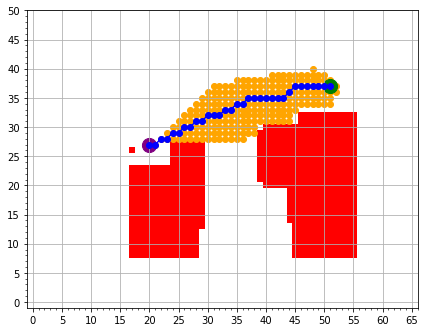

In [7]:
#np.set_printoptions(threshold=sys.maxsize)
####################################
## INIT
####################################
nb_frame_to_take = 10
# Prend une première image
for i in range (nb_frame_to_take): 
    ret, frame = VideoCap.read()
    
print("taille frame", frame.shape)
cv2.imwrite("debut.jpg", frame)

print("MAP INITIALISATION")
# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)
#print("Pourcentage",Lausanne.get_pourcentage())
# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())
#goal = (50, 40)

# Set pour relancer direct
pos_robot = (-1,-1)
George.set_pos(pos_robot) 
#print("GOAL", goal)

print("first while")
#pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
 
      #Utiliser au cas où il ne trouve pas la bonne position du premier coup
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    #ret, frame=VideoCap.read()
    #display(frame,1,0,0)
    print("searching for the strart pos")
    ret, frame=VideoCap.read()
    #vs.display (frame, 0, 1, 1, 0, 5, Lausanne.get_pourcentage())
    pos_robot, angle, bool_measure = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
    #print("Waiting robot position") 

George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
print ("goal", goal)
print ("start position", pos_robot)

# SET MAP
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
mask_bleu, mask_green = mask_map_init(frame)
#cv2.imshow("mask", mask)
cv2.imwrite("masque1.jpg", mask_bleu)
cv2.imwrite("masque2.jpg", mask_green)

# Fin de l'init
Lausanne.init_grid(mask_bleu,mask_green)
grille = Lausanne.get_map()
#cv2.imshow("grid", grille)
cv2.imwrite("grille.jpg", grille)

# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 

# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())
#print("PATH", George.get_path())

display (frame, 0, 1, 1, 1, George.get_path(), Lausanne.get_pourcentage())
#print("PATH22222", George.get_path())
cv2.imwrite("TOTAL.jpg", frame)

#vision_end(VideoCap)



In [8]:
import time

In [9]:

####################################
## while
####################################

George.set_current(0)
current= 0
bool_measure = False
#print("PATH", George.get_path())
old_distance = 0
old_angle = 0
soon_arrived = False
thresh_indentation = 15

KF=KalmanFilter(0.1, [0.0, 0])
x_old = 0
y_old = 0
position_robot =np.array([0,0])

print('START MOUVEMENT')
while True:#(George.get_pos() != George.get_goal()):
    start = time.time()
    
    etat = KF.predict().astype(np.float64)
    #print('etat est de la forme',etat)
    #print(etat[0,0])
    
       
    position_robot[0] = etat[0][0]
    position_robot[1] = etat[1][0]
    
    # Read the camera
    ret, frame=VideoCap.read()
    
    # Recupere la position et angle --> XAV
    pos_camera,angle_robot,bool_measure = update(frame, Lausanne.get_pourcentage())
    
    if bool_measure:
        etat
        speed = ( 100 + 100)/ 2
        speed = speed / 45.045
        print(' la vitesse moyen est', speed)

        speed_x = speed*np.cos(angle_robot)
        speed_y = speed*np.sin(angle_robot)

        if (len(pos_robot)>0):
            array = np.array([ 0,0,0,0.0])
            array[0] = float(pos_camera[0])
            array[1] = float(pos_camera[1])
            array[2] = float(speed_x)
            array[3] = float(speed_y)

            KF.update(np.expand_dims(array, axis=-1))
            
    print(' bool detect est',  bool_measure)
    print('la position du robot est', position_robot)
    print(' les points du kF sont', etat)
    
    
    George.set_pos(position_robot)
    George.set_angle(angle_robot)
    
    if(current < George.get_path().shape[1]-1):
        current = path_update(position_robot, ERR_POS, np.transpose(George.get_path())[current], George.get_current())
        George.set_current(current)
    else:
        print("ARRIVED")
        motors(0,0)
        break
    
    #print("pos", pos_robot)
    print("taille", George.get_path().shape[1])
    print("current", current)
    pos_goal =  np.transpose(George.get_path())[current]
    
    if current > (George.get_path().shape[1] - thresh_indentation) :
        soon_arrived = True
        print('soon arrived')
    
    proximity = proxi()
    print ('proximity', proximity)
    move = check_cars(prox_horizonta=proximity)
    print('move check cars', move)
    """
        #LOCAL NAVIGATION
    if move and not (soon_arrived):
        #Thymio is avoiding obstacles
        print("OBSTACLLLEEEE")
        speed_l, speed_r, move = avoid_obstacle(prox_horizonta=proximity) 
    else:
        #Thymio is following the optimal path
        print("Avancee")
        speed_l, speed_r, old_distance, old_goal  = move_to_position(pos_robot, angle_robot, pos_goal, old_distance, old_angle)
        #Thymio is checking if there's an obstacle in front of it
        move = check_cars(prox_horizonta=proximity)
        print (speed_l, speed_r)
       
    """
    speed_l, speed_r, old_distance, old_goal  = move_to_position(position_robot, angle_robot, pos_goal, old_distance, old_angle)
    motors(speed_l, speed_r) 
    
    
    display (frame, 0, 1, 1, 1, path, Lausanne.get_pourcentage())
    
    end = time.time()

    print('le temps d execution est de',end - start)
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)

print("The End")
    

START MOUVEMENT
 la vitesse moyen est 2.22000222000222
update 2 E [[34.]
 [25.]
 [-2.]
 [ 0.]]
 bool detect est True
la position du robot est [0 0]
 les points du kF sont [[0.]
 [0.]
 [0.]
 [0.]]
PATH [51 37]
X 51
Y 37
taille 32
current 0
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[0 0]
old dist, 0 old angle 0
debut 0 0 3.049263318858194
dist_debut 63.00793600809346
-2.4216338930566996
new dist, 63.00793600809346 new angle -2.4216338930566996
speed_original, 484 -484
speed, 200 -484
le temps d execution est de 0.02600693702697754
 la vitesse moyen est 2.22000222000222
update 2 E [[45.]
 [33.]
 [-2.]
 [ 0.]]
 bool detect est True
la position du robot est [33 25]
 les points du kF sont [[33.8]
 [25. ]
 [-2. ]
 [ 0. ]]
PATH [51 37]
X 18
Y 12
taille 32
current 0
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[33 25]
old dist, 63.00793600809346 old angle 0
debut 33 25 3.047531418961807
dist_debut 21.633307652783937
-2.459528815414239
new dist, 21.63330765

 la vitesse moyen est 2.22000222000222
update 2 E [[50.]
 [37.]
 [-2.]
 [ 0.]]
 bool detect est True
la position du robot est [49 37]
 les points du kF sont [[49.8]
 [37.1]
 [-2. ]
 [ 1. ]]
PATH [47 37]
X 2
Y 0
next goal plz
taille 32
current 5
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[49 37]
old dist, 3.0 old angle 0
debut 49 37 2.961739153797315
dist_debut 3.0
0.1798534997924781
new dist, 3.0 new angle 0.1798534997924781
speed_original, 60 131
speed, 60 131
le temps d execution est de 0.03205442428588867
 la vitesse moyen est 2.22000222000222
update 2 E [[50.]
 [37.]
 [-2.]
 [ 0.]]
 bool detect est True
la position du robot est [49 37]
 les points du kF sont [[49.8]
 [37. ]
 [-2. ]
 [ 0. ]]
PATH [46 37]
X 3
Y 0
taille 32
current 5
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[49 37]
old dist, 3.0 old angle 0
debut 49 37 3.0126818819058014
dist_debut 3.0
0.12891077168399168
new dist, 3.0 new angle 0.12891077168399168
speed_original, 70 121
speed

 la vitesse moyen est 2.22000222000222
update 2 E [[46.]
 [37.]
 [-2.]
 [-1.]]
 bool detect est True
la position du robot est [46 37]
 les points du kF sont [[46.8]
 [37. ]
 [-2. ]
 [ 0. ]]
PATH [43 35]
X 3
Y 2
taille 32
current 8
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[46 37]
old dist, 3.605551275463989 old angle 0
debut 46 37 -2.837591714249649
dist_debut 3.605551275463989
6.5671869713870095
new dist, 3.605551275463989 new angle 0.28400166420742323
speed_original, 40 154
speed, 40 154
le temps d execution est de 0.030032634735107422
 la vitesse moyen est 2.22000222000222
update 2 E [[46.]
 [37.]
 [-2.]
 [-1.]]
 bool detect est True
la position du robot est [45 36]
 les points du kF sont [[45.8]
 [36.9]
 [-2. ]
 [-1. ]]
PATH [43 35]
X 2
Y 1
next goal plz
taille 32
current 9
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[45 36]
old dist, 3.605551275463989 old angle 0
debut 45 36 -2.796037073008081
dist_debut 3.1622776601683795
6.259380280994517


 la vitesse moyen est 2.22000222000222
update 2 E [[43.]
 [36.]
 [-2.]
 [-0.]]
 bool detect est True
la position du robot est [42 36]
 les points du kF sont [[42.8]
 [36. ]
 [-2. ]
 [ 0. ]]
PATH [39 35]
X 3
Y 1
taille 32
current 12
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[42 36]
old dist, 3.1622776601683795 old angle 0
debut 42 36 -3.0309354324158977
dist_debut 3.1622776601683795
6.494278640402333
new dist, 3.1622776601683795 new angle 0.2110933332227467
speed_original, 54 138
speed, 54 138
le temps d execution est de 0.0350339412689209
 la vitesse moyen est 2.22000222000222
update 2 E [[43.]
 [36.]
 [-2.]
 [-1.]]
 bool detect est True
la position du robot est [42 36]
 les points du kF sont [[42.8]
 [36. ]
 [-2. ]
 [ 0. ]]
PATH [39 35]
X 3
Y 1
taille 32
current 12
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[42 36]
old dist, 3.1622776601683795 old angle 0
debut 42 36 -2.8966139904629293
dist_debut 3.1622776601683795
6.359957198449365
new dist, 

 la vitesse moyen est 2.22000222000222
update 2 E [[39.]
 [35.]
 [-2.]
 [-0.]]
 bool detect est True
la position du robot est [38 35]
 les points du kF sont [[38.8]
 [35. ]
 [-2. ]
 [ 0. ]]
PATH [36 34]
X 2
Y 1
next goal plz
taille 32
current 16
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[38 35]
old dist, 3.1622776601683795 old angle 0
debut 38 35 -2.9971510752151493
dist_debut 3.1622776601683795
6.460494283201585
new dist, 3.1622776601683795 new angle 0.17730897602199835
speed_original, 60 131
speed, 60 131
le temps d execution est de 0.03000664710998535
 la vitesse moyen est 2.22000222000222
update 2 E [[39.]
 [35.]
 [-2.]
 [-0.]]
 bool detect est True
la position du robot est [38 35]
 les points du kF sont [[38.8]
 [35. ]
 [-2. ]
 [ 0. ]]
PATH [35 34]
X 3
Y 1
taille 32
current 16
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[38 35]
old dist, 3.1622776601683795 old angle 0
debut 38 35 -2.9441970937399122
dist_debut 3.1622776601683795
6.4075403017

 la vitesse moyen est 2.22000222000222
update 2 E [[35.]
 [34.]
 [-2.]
 [-1.]]
 bool detect est True
la position du robot est [34 34]
 les points du kF sont [[34.8]
 [34. ]
 [-2. ]
 [ 0. ]]
PATH [32 32]
X 2
Y 2
next goal plz
taille 32
current 20
soon arrived
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[34 34]
old dist, 3.605551275463989 old angle 0
debut 34 34 -2.8706458032513726
dist_debut 3.605551275463989
6.600241060388733
new dist, 3.605551275463989 new angle 0.3170557532091469
speed_original, 33 160
speed, 33 160
le temps d execution est de 0.03402853012084961
 la vitesse moyen est 2.22000222000222
update 2 E [[35.]
 [34.]
 [-2.]
 [-1.]]
 bool detect est True
la position du robot est [34 33]
 les points du kF sont [[34.8]
 [33.9]
 [-2. ]
 [-1. ]]
PATH [31 32]
X 3
Y 1
taille 32
current 20
soon arrived
proximity [0, 0, 0, 0, 0, 0, 0]
move check cars False
movement
[34 33]
old dist, 3.605551275463989 old angle 0
debut 34 33 -2.791278441354391
dist_debut 3.162277660

 la vitesse moyen est 2.22000222000222
update 2 E [[31.]
 [32.]
 [-2.]
 [-1.]]
 bool detect est True
la position du robot est [31 31]
 les points du kF sont [[31.8]
 [31.9]
 [-2. ]
 [-1. ]]
PATH [28 31]
X 3
Y 0
taille 32
current 23
soon arrived
proximity [0, 1637, 3485, 1648, 0, 0, 0]
move check cars True
movement
[31 31]
old dist, 3.0 old angle 0
debut 31 31 -2.7577750303012243
dist_debut 3.0
5.899367683891017
new dist, 3.0 new angle -0.38381762328856883
speed_original, 172 19
speed, 172 19
le temps d execution est de 0.030010223388671875
 la vitesse moyen est 2.22000222000222
update 2 E [[31.]
 [32.]
 [-2.]
 [-1.]]
 bool detect est True
la position du robot est [30 31]
 les points du kF sont [[30.8]
 [31.9]
 [-2. ]
 [-1. ]]
PATH [28 31]
X 2
Y 0
next goal plz
taille 32
current 24
soon arrived
proximity [0, 1728, 4133, 4592, 0, 0, 0]
move check cars True
movement
[30 31]
old dist, 3.0 old angle 0
debut 30 31 -2.7868870015788527
dist_debut 3.1622776601683795
6.250230209565288
new dist, 

 la vitesse moyen est 2.22000222000222
update 2 E [[30.]
 [31.]
 [-2.]
 [-0.]]
 bool detect est True
la position du robot est [29 30]
 les points du kF sont [[29.8]
 [30.9]
 [-2. ]
 [-1. ]]
PATH [26 30]
X 3
Y 0
taille 32
current 25
soon arrived
proximity [1699, 4189, 4580, 4637, 0, 0, 0]
move check cars True
movement
[29 30]
old dist, 3.0 old angle 0
debut 29 30 -2.9304993203670464
dist_debut 3.0
6.072091973956839
new dist, 3.0 new angle -0.2110933332227467
speed_original, 138 53
speed, 138 53
le temps d execution est de 0.031034231185913086
 la vitesse moyen est 2.22000222000222
update 2 E [[30.]
 [31.]
 [-2.]
 [-0.]]
 bool detect est True
la position du robot est [29 31]
 les points du kF sont [[29.8]
 [31. ]
 [-2. ]
 [ 0. ]]
PATH [26 30]
X 3
Y 1
taille 32
current 25
soon arrived
proximity [1699, 4189, 4580, 4637, 0, 0, 0]
move check cars True
movement
[29 31]
old dist, 3.0 old angle 0
debut 29 31 -2.9476335063299004
dist_debut 3.1622776601683795
6.410976714316336
new dist, 3.1622776

In [9]:
vision_end(VideoCap)

In [10]:
motors(0,0)